# Overview

Welcome to the assignment notebook of Sándor Gregus(YRVTLZ), Katalin Ócsai (EW9A0Z), and József Mátyás Prechl (JR4JDJ)!

We decided to work on a larger and simpler database: CelebA.
We have reviewed not only the recommended GAN literature (https://paperswithcode.com/paper/progressive-growing-of-gans-for-improved )
but also VAEs and beta VAEs.




* Chosen topic:

*Cél:  Az arckép jellemzőinek a felismerése. Első lépésben címkézett adatok alapján az adatbázisban található címkékre készítsetek minél jobb modellt. További opcionális lépésként VAE (és/vagy GAN) alapú architektúrával célszerű kísérletezni, hogy a látens változók milyen arc jellemzőket tanulnak meg - akár felismerés, akár generálás idején.* 

*Előny: könnyű nagy mennyiségű adatot beszerezni; de mégis a jó minőségű képek szintéziséhez sok trükk kell*

*Kiindulás: https://paperswithcode.com/paper/progressive-growing-of-gans-for-improved* 

*Adatbázis: https://github.com/dchen236/FairFace, de mást is lehet használni*



*   *Tasks*: 

*   *Adatok beszerzése, adatfeltárás, vizualizáció (ha szükséges) és előkészítés tanításhoz*
*   *Eredmény: tanító, validációs és teszt adatbázisok*

# Download data



Easier access to CelebA database from our own Google Drive.
Unzipping more than 200k files from the zip takes less than a minute.

In [ ]:
!mkdir celebA

In [ ]:
%cd celebA

/content/celebA


In [ ]:
!gdown --id 1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW

Downloading...
From: https://drive.google.com/uc?id=1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW
To: /content/celebA/img_align_celeba.zip
100% 1.44G/1.44G [00:09<00:00, 151MB/s]


In [ ]:
!gdown --id 1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3

Downloading...
From: https://drive.google.com/uc?id=1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3
To: /content/celebA/list_attr_celeba.csv
100% 24.9M/24.9M [00:00<00:00, 151MB/s]


In [ ]:
!unzip img_align_celeba.zip

A streamkimeneten csak az utolsó 5000 sor látható.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

# Get the attributes and do some exploration of the data



*   We checked whether the table of attributes contains empty values
*   We checked whether the table of attributes contains only binary values
*   We checked whether the image database contains (quasi)constant images
*   We checked whether the size of image database matches the size of attribute table



To check the data and attributes we decided to use pandas package.
We imported the table of attributes and had a quick sanity check.

In [ ]:
import pandas as pd

In [ ]:

# import the data set that includes the attributes for each picture
df_attr = pd.read_csv('list_attr_celeba.csv', sep=';')
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


Check for empty / null values in the table

In [ ]:
import numpy as np
np.where(pd.isnull(df_attr))

(array([], dtype=int64), array([], dtype=int64))

Check the different values for each binary attributes. 
We found that all of them were 2 (as it should be)

In [ ]:
df2 = pd.DataFrame(df_attr)
df2.nunique()

image_id               202599
5_o_Clock_Shadow            2
Arched_Eyebrows             2
Attractive                  2
Bags_Under_Eyes             2
Bald                        2
Bangs                       2
Big_Lips                    2
Big_Nose                    2
Black_Hair                  2
Blond_Hair                  2
Blurry                      2
Brown_Hair                  2
Bushy_Eyebrows              2
Chubby                      2
Double_Chin                 2
Eyeglasses                  2
Goatee                      2
Gray_Hair                   2
Heavy_Makeup                2
High_Cheekbones             2
Male                        2
Mouth_Slightly_Open         2
Mustache                    2
Narrow_Eyes                 2
No_Beard                    2
Oval_Face                   2
Pale_Skin                   2
Pointy_Nose                 2
Receding_Hairline           2
Rosy_Cheeks                 2
Sideburns                   2
Smiling                     2
Straight_H

Check for the number of rows, which must be the same as the number of images (as we saw 202599)

In [ ]:
df_attr.shape

(202599, 41)

In [ ]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [ ]:
import random
import os
import csv
import numpy as np

crsPath = 'img_align_celeba'

In [ ]:
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


,Male,Wearing_Lipstick,Blurry,Wearing_Hat
131965,0,1,0,0


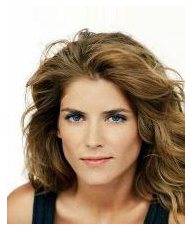

In [ ]:
#random example
img_name = random.choice(os.listdir(crsPath))
img = load_img(crsPath + os.sep + img_name)
plt.grid(False)
plt.axis('off')
plt.imshow(img)
df_attr.loc[df_attr['image_id'] == img_name][random.sample(list(df_attr.columns), len(df_attr.columns))[:4]] #some attributes

# Split the dataset to train/test/val data

To split the dataset we used random permutation of the data in the ration of 0.8: 0.1 : 0.1
Then we checked whether the distribution of train / test / split are the same in the different attributes.

In [ ]:
#setup ratio (val ratio = rest of the files in origin dir after splitting into train and test)
train_ratio = 0.8
test_ratio = 0.1


#total count of imgs
totalImgCount = len(os.listdir(crsPath))
print("total img count:", totalImgCount)
countForTrain = int(totalImgCount*train_ratio)
countForTest = int(totalImgCount*test_ratio)
countForValid = totalImgCount - countForTrain - countForTest

print("train count:", countForTrain)
print("test count:", countForTest)
print("val count:", countForValid)
randPermute = np.random.permutation(totalImgCount)

with open('list_eval_partition.csv','w') as f:
    writer = csv.writer(f)

    #cycle for train dir
    for x in range(countForTrain):
        counter = randPermute[x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','0'])

    #cycle for test dir
    for x in range(countForTest):
        counter = randPermute[countForTrain + x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','1'])    

    #cycle for valid  dir
    for x in range(countForValid):
        counter = randPermute[countForTrain + countForTest + x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','2'])

total img count: 202599
train count: 162079
test count: 20259
val count: 20261


In [ ]:
df_split = pd.read_csv('list_eval_partition.csv', names=['image_id', 'split'])

In [ ]:
df_buff = df_attr.merge(df_split, on=["image_id"])
df_buff = df_buff.sort_index()
df_buff.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,split
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
df_train = df_buff[df_buff['split'] == 0]
df_test = df_buff[df_buff['split'] == 1]
df_val = df_buff[df_buff['split'] == 2]

In [ ]:
train_attr_perc = df_train.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)
test_attr_perc = df_test.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)
val_attr_perc = df_val.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)

In [ ]:
df_plot = train_attr_perc.transpose().join(test_attr_perc.transpose(), lsuffix='train', rsuffix='test').join(val_attr_perc.transpose())
df_plot.columns = ['train', 'test', 'val']
df_plot.head()

,train,test,val
5_o_Clock_Shadow,0.111150,0.113382,0.108780
Arched_Eyebrows,0.266506,0.266844,0.270915
Attractive,0.512226,0.516511,0.510735
Bags_Under_Eyes,0.204968,0.202478,0.203494
Bald,0.022464,0.021571,0.023148


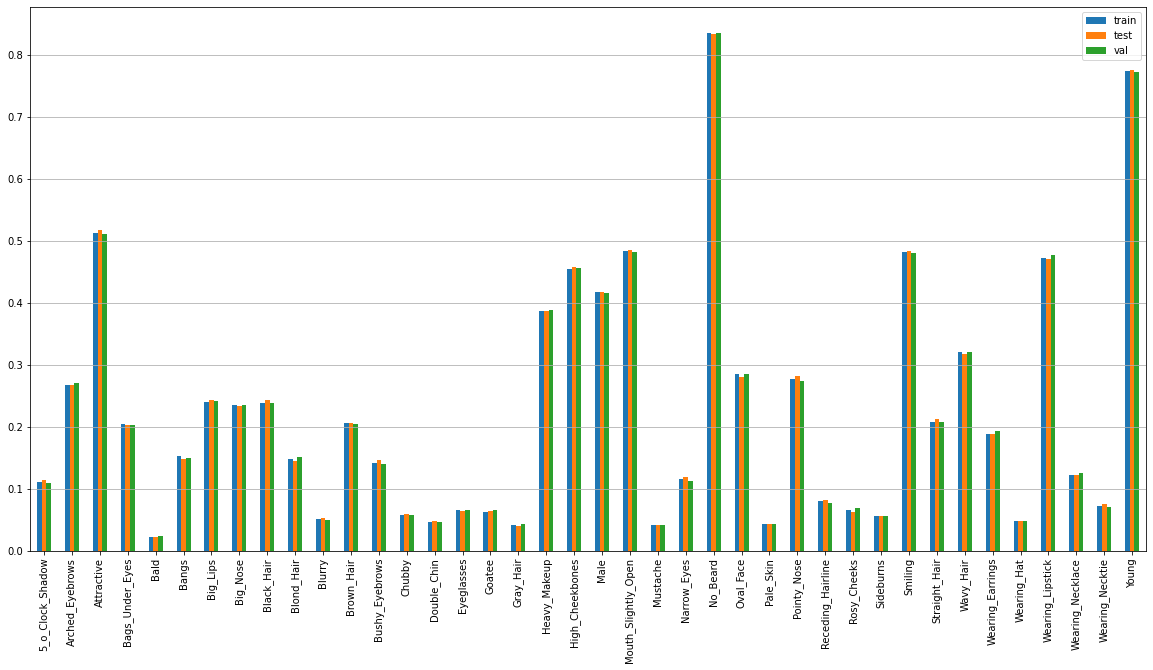

In [ ]:
df_plot.plot(kind='bar', figsize=(20,10)).grid(axis='y')